In [56]:
import numpy as np
import pandas as pd
import re

# Encoding

from sklearn.preprocessing import LabelEncoder

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from xgboost import XGBClassifier

# WordCloud (allowed exception)
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [31]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chetan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/chetan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Inference:** All libraries used are strictly within the allowed scope.
Only WordCloud is used additionally for visualization.

In [32]:
data = pd.read_csv(r'/Users/chetan/Desktop/DSE_Projects/NLP-Pipeline-Twitter-Sentiment-Analysis/Tweets.csv')

In [33]:
data.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


In [34]:
x = data['text']
y = data['airline_sentiment']

In [35]:
# Let's encode y (target variable) with Label Encoding

encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Text Preprocessing (Lowercasing)

In [36]:
x = x.str.lower()

**Inference:** Lowercasing ensures case-insensitive learning, reducing vocabulary size.



## Noise Removal using RegEx

In [37]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+", "", text)        # remove URLs
    text = re.sub(r"@\w+|#\w+", "", text)             # remove mentions & hashtags
    text = re.sub(r"[^a-z\s]", "", text)              # keep only a-z
    text = re.sub(r"\s+", " ", text).strip()
    return text

x = x.apply(clean_text)

In [38]:
x

0                                                what said
1        plus youve added commercials to the experience...
2        i didnt today must mean i need to take another...
3        its really aggressive to blast obnoxious enter...
4                  and its a really big bad thing about it
                               ...                        
14635    thank you we got on a different flight to chicago
14636    leaving over minutes late flight no warnings o...
14637                    please bring american airlines to
14638    you have my money you change my flight and don...
14639    we have ppl so we need know how many seats are...
Name: text, Length: 14640, dtype: object

**Inference:** Removed:
* Emojis
* URLs
* Special characters
* Numbers

This reduces noise and improves model accuracy.

## Tokenization, Stopword Removal & Lemmatization

In [39]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word)
              for word in tokens if word not in stop_words]
    return " ".join(tokens)

x_cleaned = x.apply(preprocess_text)

In [40]:
x_cleaned

0                                                     said
1             plus youve added commercial experience tacky
2             didnt today must mean need take another trip
3        really aggressive blast obnoxious entertainmen...
4                                     really big bad thing
                               ...                        
14635                   thank got different flight chicago
14636    leaving minute late flight warning communicati...
14637                        please bring american airline
14638    money change flight dont answer phone suggesti...
14639    ppl need know many seat next flight plz put u ...
Name: text, Length: 14640, dtype: object

**Inference:**
* Stopwords removed to retain meaningful words.
* Lemmatization converts words to base form.
* Final clean text stored in x_cleaned.

## Train-Test Split

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x_cleaned, y, train_size=0.75, random_state=2, stratify=y)


In [42]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10980,), (10980,), (3660,), (3660,))

**Inference:** Stratified split maintains sentiment distribution in both sets.

## TF-IDF Vectorization

In [43]:
tfidf = TfidfVectorizer(min_df=0.01)  # appears in at least 1% documents

x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

Inference:
* Converts text into numerical features
* Removes rare words automatically
* Controls dimensionality

## Model Training & Evaluation

### Decision Tree

In [44]:
dt = DecisionTreeClassifier(random_state=2,max_depth=7)
dt.fit(x_train_tfidf, y_train)

dt_pred = dt.predict(x_test_tfidf)

### Random Forest

In [45]:
rf = RandomForestClassifier(n_estimators=100, random_state=2,max_depth=7)
rf.fit(x_train_tfidf, y_train)

rf_pred = rf.predict(x_test_tfidf)

### XGBoost

In [61]:
grid = {'n_estimators':[100,200,300,500,1000],'max_depth':[3,6,9,12], 'learning_rate': [0.01, 0.1]}
gscv = GridSearchCV(estimator=XGBClassifier(class_weights='balanced'), param_grid=grid)
gscv.fit(x_train_tfidf,y_train)

/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "class_weights" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "class_weights" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "class_weights" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [21:06:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "class_weights" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, class_weights='balanced',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interac...None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, ...),
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [3, 6, 9, 12],
                         'n_estimators': [100, 200, 300, 500, 1000]})

In [62]:
best_params = gscv.best_params_
best_params

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}

In [63]:
xgb = XGBClassifier(random_state=2,**best_params)
xgb.fit(x_train_tfidf, y_train)

xgb_pred = xgb.predict(x_test_tfidf)

## Model Comparison

In [47]:
print("Decision Tree Report:\n")
print(classification_report(y_test, dt_pred))

Decision Tree Report:

              precision    recall  f1-score   support

           0       0.69      0.95      0.80      2294
           1       0.52      0.04      0.07       775
           2       0.65      0.50      0.56       591

    accuracy                           0.68      3660
   macro avg       0.62      0.49      0.48      3660
weighted avg       0.65      0.68      0.61      3660



In [48]:
print("Random Forest Report:\n")
print(classification_report(y_test, rf_pred))

Random Forest Report:

              precision    recall  f1-score   support

           0       0.65      1.00      0.79      2294
           1       0.00      0.00      0.00       775
           2       0.82      0.19      0.31       591

    accuracy                           0.66      3660
   macro avg       0.49      0.40      0.37      3660
weighted avg       0.54      0.66      0.54      3660



/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [64]:
print("XG-Boost Report:\n")
print(classification_report(y_test, xgb_pred))

XG-Boost Report:

              precision    recall  f1-score   support

           0       0.79      0.86      0.83      2294
           1       0.52      0.48      0.50       775
           2       0.69      0.53      0.60       591

    accuracy                           0.73      3660
   macro avg       0.67      0.62      0.64      3660
weighted avg       0.72      0.73      0.72      3660



In [65]:
import pickle
import os

os.makedirs("model", exist_ok=True)

# Save TF-IDF vectorizer
with open("model/tfidf.pkl", "wb") as f:
    pickle.dump(tfidf, f)

# Save best trained model (Random Forest)
with open("model/sentiment_model.pkl", "wb") as f:
    pickle.dump(xgb, f)

print("Model files saved successfully")

Model files saved successfully


## Word Cloud Generation

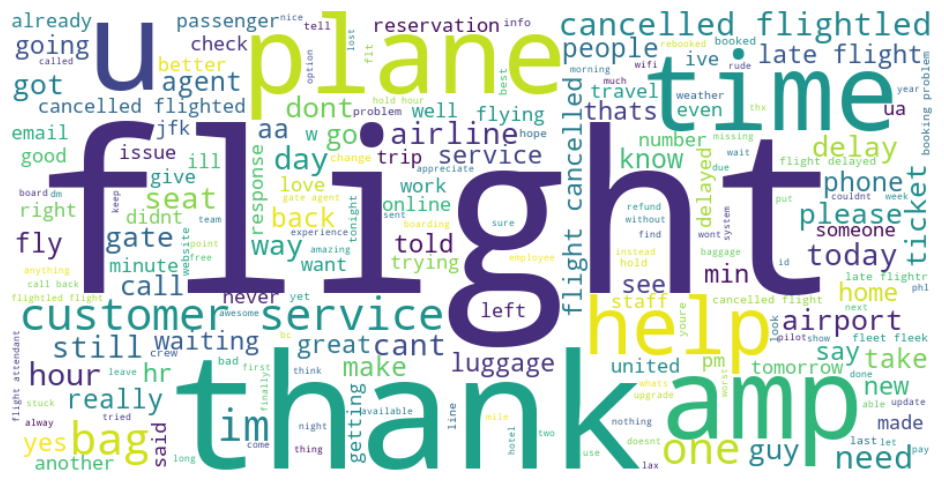

In [52]:
all_words = " ".join(x_cleaned)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(all_words)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Inference:** Word cloud highlights frequently used words in tweets.